In [1]:
import sys
sys.path.append("/home/vivekm/captum-1/")

In [2]:
import torch
import torchvision
from torchvision import transforms
import torchvision.models as models

In [3]:
%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from captum.attr import IntegratedGradientsExp, IntegratedGradients
from captum.attr import visualization as viz

In [4]:
model_conv = torchvision.models.inception_v3(pretrained='imagenet')
model_conv.eval()
model_conv_cuda = model_conv.cuda()

In [5]:
def model_with_softmax(inp):
    out = model_conv_cuda(inp)
    return torch.nn.functional.softmax(out, dim=1)

In [6]:
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 ])
mean=torch.tensor([0.485, 0.456, 0.406]).reshape(1,3,1,1)                #[6]
std=torch.tensor([0.229, 0.224, 0.225]).reshape(1,3,1,1)                #[7]


In [7]:
imagenet_data = torchvision.datasets.ImageNet('/home/vivekm/imagenet/',split="val",transform=transform)
data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=1,shuffle=True)

In [8]:
def split_ig(model, inp, target, baseline=None, ratio=0.5):
    final_out = model(inp)[:,target].item()
    if baseline is None:
        baseline = torch.zeros_like(inp)
    baseline_out = model(baseline)[:, target].item()
    threshold = baseline_out + ratio*(final_out - baseline_out)
    ig_exp = IntegratedGradientsExp(model)
    grads, outputs, steps, scaled_features = ig_exp.attribute(inp, target=target, method="riemann_right", baselines=baseline,n_steps=200, internal_batch_size=100)
    threshold_index = None
    for i in range(len(outputs)):
        if outputs[i] > threshold:
            threshold_index = i
            break
    print(threshold_index)
    steps = steps.reshape((len(steps),) + (1,)*(len(inp.shape) - 1)).to(inp.device)
    left_ig = (grads[:threshold_index]*steps[:threshold_index])*(inp-baseline)
    right_ig = (grads[threshold_index:]*steps[threshold_index:])*(inp-baseline)
    return left_ig.sum(dim=0,keepdim=True), right_ig.sum(dim=0,keepdim=True), threshold_index

In [8]:
def area_betw_pert_curves(model, attr, inp, target, baseline):
    model_out = model(inp)[:,target].item()
    baseline_out = model(baseline)[:,target].item()
    #print("Model Output:", model_out)
    #print("Baseline Output:", baseline_out)
    #print("Attr Shape:", attr.shape)
    attr_sum = attr.sum(dim=1,keepdim=True)
    #print("Attr Sum Shape:", attr_sum.shape)
    attr_vals,_ = torch.sort(torch.flatten(attr_sum))
    #print("Attr vals sum", attr_vals.sum())
    all_diffs = 0
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for threshold in thresholds:
        #print("Threshold:", threshold)
        #print("Bottom Threshold:", attr_vals[int(len(attr_vals)*threshold)])
        #print("Top Threshold:", attr_vals[-1*int(len(attr_vals)*threshold)])
        #print("Bottom Mask Shape", (attr_sum > attr_vals[int(len(attr_vals)*threshold)]).float().shape)
        #print("Bottom Mask Sum", (attr_sum > attr_vals[int(len(attr_vals)*threshold)]).float().sum())
        #print("Top Mask Shape", (attr_sum < attr_vals[-1*int(len(attr_vals)*threshold)]).float().shape)
        #print("Top Mask Sum", (attr_sum < attr_vals[-1*int(len(attr_vals)*threshold)]).float().sum())
        bottom_ablated = (attr_sum > attr_vals[int(len(attr_vals)*threshold)]).float() * inp
        top_ablated = (attr_sum < attr_vals[-1*int(len(attr_vals)*threshold)]).float() * inp
        bottom_ablated_res = model(bottom_ablated)[:,target].item()
        top_ablated_res = model(top_ablated)[:,target].item()
        #print("Bottom Ablated Result:", bottom_ablated_res)
        #print("Top Ablated Result:", top_ablated_res)
        #print("Normalized Bottom:", min(max((bottom_ablated_res - baseline_out) / (model_out - baseline_out), 0), 1))
        #print("Normalized Top:", min(max((top_ablated_res - baseline_out) / (model_out - baseline_out), 0), 1))
        diff = min(max((bottom_ablated_res - baseline_out) / (model_out - baseline_out), 0), 1) - min(max((top_ablated_res - baseline_out) / (model_out - baseline_out), 0), 1)
        #print("Diff:",diff)
        all_diffs += max(diff, 0)
    return all_diffs / (len(thresholds) + 1)

In [9]:
def sensitivity(attr_fn, inp, radius=0.1):
    orig_left, orig_right, _ = attr_fn(inp)
    max_diff_left = 0
    max_diff_right = 0
    max_diff_overall = 0
    for i in range(10):
        perturb = (torch.rand_like(inp) * (2 * radius)) - radius
        diff_left, diff_right, _ = attr_fn(inp + perturb)
        curr_left_sens = torch.norm(diff_left - orig_left, p='fro') / torch.norm(orig_left, p='fro')
        curr_right_sens = torch.norm(diff_right - orig_right, p='fro') / torch.norm(orig_right, p='fro')
        curr_overall_sens = torch.norm((diff_left + diff_right) - (orig_left + orig_right), p='fro') / torch.norm(orig_left + orig_right, p='fro')
        if curr_overall_sens > max_diff_overall:
            max_diff_overall = curr_overall_sens
        if curr_right_sens > max_diff_right:
            max_diff_right = curr_right_sens
        if curr_left_sens > max_diff_left:
            max_diff_left = curr_left_sens
    return max_diff_left, max_diff_right, max_diff_overall


In [10]:
saved_image = None
saved_label = None
rel_mag = []
rel_l1_norm = []
rel_sum = []
thresholds = []
area_left = []
area_right = []
area_overall = []
sens_left_all = []
sens_right_all = []
sens_overall_all = []
cos_sim_left_right = []
cos_sim_left_overall = []
cos_sim_right_overall = []
split_ratio = 0.95
for id, batch in enumerate(data_loader):
    saved_image, saved_label = batch
    normalized_image = ((saved_image - mean) / std).cuda()
    #normalized_baseline = ((torch.zeros_like(saved_image) - mean) / std).cuda()
    #if not (model_conv_cuda(normalized_image).topk(1).indices.cpu() == saved_label).item():
    #    continue
    if not (model_conv_cuda(normalized_image)[:, saved_label].item() - model_conv_cuda(torch.zeros_like(normalized_image))[:, saved_label].item()) > 5:
        print("Skipping!")
        continue
    left_ig, right_ig, threshold = split_ig(model_conv_cuda, normalized_image, target=saved_label.item(), ratio=split_ratio)
    rel_mag.append(torch.norm(right_ig, p='fro') / torch.norm(left_ig, p='fro'))
    rel_l1_norm.append(torch.sum(torch.abs(right_ig)) / torch.sum(torch.abs(left_ig)))
    rel_sum.append((torch.sum(right_ig) / torch.sum(left_ig)).item())
    thresholds.append(threshold)
    baseline = torch.zeros_like(normalized_image)
    area_left.append(area_betw_pert_curves(model_conv_cuda, left_ig, normalized_image, saved_label.item(), baseline))
    area_right.append(area_betw_pert_curves(model_conv_cuda, right_ig, normalized_image, saved_label.item(), baseline))
    area_overall.append(area_betw_pert_curves(model_conv_cuda, left_ig + right_ig, normalized_image, saved_label.item(), baseline))
    sens_left, sens_right, sens_overall = sensitivity(lambda inp: split_ig(model_conv_cuda, inp, target=saved_label.item(), ratio=split_ratio), normalized_image, radius=0.05)
    sens_left_all.append(sens_left)
    sens_right_all.append(sens_right)
    sens_overall_all.append(sens_overall)
    cos_sim_left_right.append(torch.nn.functional.cosine_similarity(left_ig.flatten(), right_ig.flatten(), dim=0))
    cos_sim_left_overall.append(torch.nn.functional.cosine_similarity(left_ig.flatten(), (left_ig + right_ig).flatten(), dim=0))
    cos_sim_right_overall.append(torch.nn.functional.cosine_similarity(right_ig.flatten(), (left_ig + right_ig).flatten(), dim=0))
    #print("AreaLeft", area_left[-1])
    #print("AreaRight", area_right[-1])
    #print("AreaOverall", area_overall[-1])
    if id > 2:
        break
print("Relative Magnitude:", sum(rel_mag) / len(rel_mag))
print("Relative Sum:", sum(rel_sum) / len(rel_sum))
print("Relative L1:", sum(rel_l1_norm) / len(rel_l1_norm))
print("ABPW Left:", sum(area_left) / len(area_left))
print("ABPW Right:", sum(area_right) / len(area_right))
print("ABPW Overall:", sum(area_overall) / len(area_overall))
print("Sensitivity Left:", sum(sens_left_all) / len(sens_left_all))
print("Sensitivity Right:", sum(sens_right_all) / len(sens_right_all))
print("Sensitivity Overall:", sum(sens_overall_all) / len(sens_overall_all))
print("Cos Sim Left / Right", sum(cos_sim_left_right) / len(cos_sim_left_right))
print("Cos Sim Left / Overall", sum(cos_sim_left_overall) / len(cos_sim_left_overall))
print("Cos Sim Right / Overall", sum(cos_sim_right_overall) / len(cos_sim_right_overall))



29
29
28
29
28
29
30
30
29
30
28
30
175
175
177
174
173
172
173
174
172
173
174
174
182
182
183
183
179
181
180
183
181
183
180
183
161
161
133
125
127
128
129
121
129
128
134
129
Relative Magnitude: tensor(0.9666, device='cuda:0')
Relative Sum: 0.05188264511525631
Relative L1: tensor(0.9115, device='cuda:0')
ABPW Left: 0.14248831995742808
ABPW Right: 0.09068724435718004
ABPW Overall: 0.13437832338364614
Sensitivity Left: tensor(0.6517, device='cuda:0')
Sensitivity Right: tensor(1.2420, device='cuda:0')
Sensitivity Overall: tensor(0.7815, device='cuda:0')
Cos Sim Left / Right tensor(0.5214, device='cuda:0')
Cos Sim Left / Overall tensor(0.8662, device='cuda:0')
Cos Sim Right / Overall tensor(0.7745, device='cuda:0')


In [28]:
sum(thresholds) / (200*len(thresholds))

0.6258333333333334

In [29]:
sum(rel_mag) / len(rel_mag)

0.8006878212423868

In [87]:
sum(area_left) / len(area_left)

0.2950570554970514

In [88]:
sum(area_right) / len(area_right)

0.07689678058368522

In [89]:
sum(area_overall) / len(area_overall)

0.23653567842938616

In [30]:
sum([1 if elem > 4 else 0 for elem in rel_mag]) / len(rel_mag)

0.05555555555555555

(array([6., 0., 2., 2., 0., 2., 0., 2., 0., 0., 0., 0., 0., 2., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.0062143 , 0.11506098, 0.22390766, 0.33275435, 0.44160103,
        0.55044771, 0.65929439, 0.76814107, 0.87698776, 0.98583444,
        1.09468112, 1.2035278 , 1.31237449, 1.42122117, 1.53006785,
        1.63891453, 1.74776122, 1.8566079 , 1.96545458, 2.07430126,
        2.18314795, 2.29199463, 2.40084131, 2.50968799, 2.61853467,
        2.72738136, 2.83622804, 2.94507472, 3.0539214 , 3.16276809,
        3.27161477, 3.38046145, 3.48930813, 3.59815482, 3.7070015 ,
        3.81584818, 3.92469486, 4.03354155, 4.14238823, 4.25123491,
        4.36008159, 4.46892827, 4.57777496, 4.68662164, 4.79546832,
        4.904315  , 5.01316169, 5.12200837, 5.23085505, 5.33970173,
        5.44854842]),
 <a list of 50 Patch objects>)

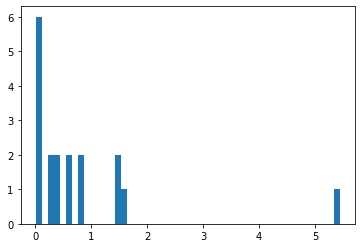

In [31]:
plt.hist(rel_mag,bins=50)

# Analyze Single Image

In [211]:
saved_image = None
saved_label = None

# Obtain random image from data loader.
for id, batch in enumerate(data_loader):
    saved_image, saved_label = batch
    break

In [212]:
normalized_image = ((saved_image - mean) / std).cuda()
# baseline = torch.randn_like(normalized_image)


In [213]:
left_ig, right_ig, threshold = split_ig(model_conv_cuda, normalized_image, target=saved_label.item(), ratio=0.99)# baseline=baseline)
print(torch.sum(left_ig))
print(torch.sum(right_ig))
print(torch.sum(left_ig ** 2))
print(torch.sum(right_ig ** 2))

28
tensor(19.1923, device='cuda:0')
tensor(-0.0048, device='cuda:0')
tensor(9.8960, device='cuda:0')
tensor(182.2708, device='cuda:0')


In [214]:
# Check if model top output is correct
(model_conv_cuda(normalized_image).topk(1).indices.cpu() == saved_label).item()

False

([], <a list of 0 Text yticklabel objects>)

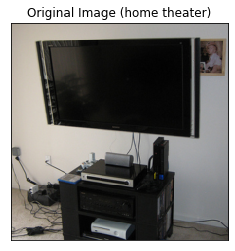

In [215]:
plt.imshow(saved_image[0].permute(1,2,0))
plt.title("Original Image (" + imagenet_data.classes[saved_label][0] +")")
plt.xticks([], [])
plt.yticks([], [])


In [216]:
imagenet_data.classes[saved_label][0]

'home theater'

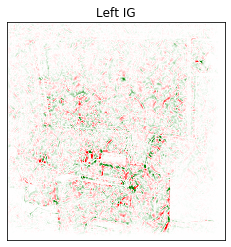

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f59f0502190>)

In [217]:
viz.visualize_image_attr(left_ig[0].cpu().permute(1,2,0).numpy(),original_image=saved_image[0].permute(1,2,0).numpy(),sign="all", title="Left IG", fig_size=(4,4))#original_image=saved_image[0].permute(1,2,0).numpy(),method="blended_heat_map")
#plt.imshow(normalized_image[0].cpu().permute(1,2,0))

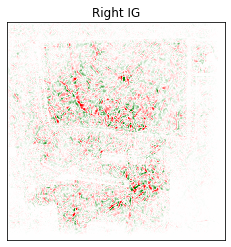

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f59f05f2a00>)

In [218]:
viz.visualize_image_attr(right_ig[0].cpu().permute(1,2,0).numpy(),sign="all", title="Right IG", fig_size=(4,4))#original_image=saved_image[0].permute(1,2,0).numpy(),method="blended_heat_map")


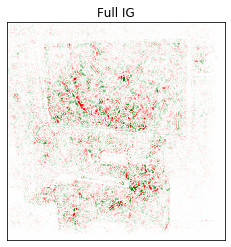

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f59f0643910>)

In [219]:
viz.visualize_image_attr((left_ig + right_ig)[0].cpu().permute(1,2,0).numpy(),sign="all", title="Full IG", fig_size=(4,4))#original_image=saved_image[0].permute(1,2,0).numpy(),method="blended_heat_map")


In [224]:
left_ig.shape

torch.Size([1, 3, 224, 224])

In [30]:
area_betw_pert_curves(model_conv_cuda, right_ig , normalized_image, saved_label, torch.zeros_like(normalized_image))

NameError: name 'area_betw_pert_curves' is not defined

In [221]:
ig_exp = IntegratedGradientsExp(model_conv_cuda)
grads, outputs, steps, scaled_features = ig_exp.attribute(normalized_image, target=saved_label.item(), method="riemann_right",n_steps=200, internal_batch_size = 100) #, baselines=baseline)

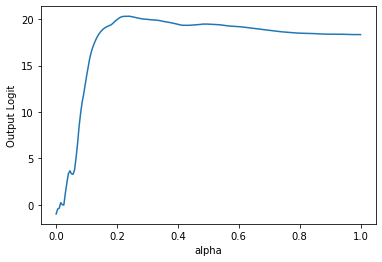

In [222]:
xvals = [a / 199 for a in range(200)]
plt.plot(xvals,outputs.detach().cpu())
plt.xlabel("alpha")
plt.ylabel("Output Logit")
plt.show()

In [223]:
for i in range(200):
    print(i, torch.norm(grads[i]))

0 tensor(5.7790, device='cuda:0')
1 tensor(8.5661, device='cuda:0')
2 tensor(8.9530, device='cuda:0')
3 tensor(10.5646, device='cuda:0')
4 tensor(14.3851, device='cuda:0')
5 tensor(14.1442, device='cuda:0')
6 tensor(18.8966, device='cuda:0')
7 tensor(23.8681, device='cuda:0')
8 tensor(25.1024, device='cuda:0')
9 tensor(22.9846, device='cuda:0')
10 tensor(23.9434, device='cuda:0')
11 tensor(25.6246, device='cuda:0')
12 tensor(33.7664, device='cuda:0')
13 tensor(41.8014, device='cuda:0')
14 tensor(44.7077, device='cuda:0')
15 tensor(44.8353, device='cuda:0')
16 tensor(42.3362, device='cuda:0')
17 tensor(39.4372, device='cuda:0')
18 tensor(38.4867, device='cuda:0')
19 tensor(37.6772, device='cuda:0')
20 tensor(37.4075, device='cuda:0')
21 tensor(33.9745, device='cuda:0')
22 tensor(30.7834, device='cuda:0')
23 tensor(25.6703, device='cuda:0')
24 tensor(23.5124, device='cuda:0')
25 tensor(22.4947, device='cuda:0')
26 tensor(22.2487, device='cuda:0')
27 tensor(22.2144, device='cuda:0')
28 te

In [42]:
torch.sum(grads * normalized_image * steps.reshape(200,1,1,1).cuda())

tensor(20.3018, device='cuda:0')

In [119]:
sensitivity(lambda inp: split_ig(model_conv_cuda, inp, target=saved_label.item(), ratio=0.9), normalized_image, radius=0.05)

54
tensor(0.0251, device='cuda:0')
47
tensor(0.0250, device='cuda:0')
45
tensor(0.0250, device='cuda:0')
55
tensor(0.0250, device='cuda:0')
49
tensor(0.0250, device='cuda:0')
53
tensor(0.0250, device='cuda:0')
50
tensor(0.0249, device='cuda:0')
52
tensor(0.0250, device='cuda:0')
50
tensor(0.0250, device='cuda:0')
52
tensor(0.0250, device='cuda:0')
54


(tensor(0.4876, device='cuda:0'),
 tensor(0.6941, device='cuda:0'),
 tensor(0.6379, device='cuda:0'))

In [ ]:
ig_exp = grads[0]*steps.reshape(200,1,1,1).cuda()*normalized_image

In [ ]:
plt.plot((ig_exp ** 2).sum(dim=(1,2,3)).cpu())

In [ ]:
saved_label